In [1081]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score,\
                            confusion_matrix, mean_absolute_error, mean_squared_error, r2_score,\
                            explained_variance_score
from scipy import stats

import warnings
warnings.simplefilter('ignore')
%matplotlib inline

# Laptop Prices

# Assignment 1

#### 1.1. Choose data set from Kaggle repo

<a href="https://www.kaggle.com/ionaskel/laptop-prices">Kaggle Laptop Prices</a>

In [1082]:
data = pd.read_csv('laptops.csv', sep=',', encoding='latin-1')
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data.shape

(1303, 12)

#### 1.2. Explore main data set features and target labels.

In [1083]:
data.head(3)

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00


In [1084]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 12 columns):
Company             1303 non-null object
Product             1303 non-null object
TypeName            1303 non-null object
Inches              1303 non-null float64
ScreenResolution    1303 non-null object
Cpu                 1303 non-null object
Ram                 1303 non-null object
Memory              1303 non-null object
Gpu                 1303 non-null object
OpSys               1303 non-null object
Weight              1303 non-null object
Price_euros         1303 non-null float64
dtypes: float64(2), object(10)
memory usage: 122.2+ KB


Пропусков нет.
Преобразуем Ram, Memory, Weight в числа

In [1085]:
data['Weight_kg'] = data['Weight'].apply(lambda x: float(x[:-2]))
data['Ram_GB'] = data['Ram'].apply(lambda x: float(x[:-2]))
data.drop(['Weight','Ram'], axis=1,inplace=True)

In [1086]:
def Get_Memory(string_memory, type_memory):
    memory = string_memory.split('+')
    value_memory=0    
    for m in memory:
        index_memory = m.find("GB "+type_memory)
        if index_memory!=-1:
            value_memory = m[:index_memory]
        
    return int(value_memory)

In [1087]:
data['SSD'] = data['Memory'].apply(lambda x: Get_Memory(x, 'SSD'))
data['HDD'] = data['Memory'].apply(lambda x: Get_Memory(x, 'HDD'))
data['Flash'] = data['Memory'].apply(lambda x: Get_Memory(x, 'Flash'))
data.drop('Memory',axis=1,inplace=True)

Преобразуем ScreenResolution в числовой признак

In [1088]:
def get_screen_resol(screen):
    resolution = screen.split()[-1]    
    width, height = resolution.split('x')     
    return float(width)*float(height)    

In [1089]:
#признак в виде произведения кол.пикселей по высоте на кол.пиксеоей по ширине
data['Resolution'] = data['ScreenResolution'].apply(get_screen_resol)

In [1090]:
def get_ghz(cpu):
    return float(cpu.split()[-1][:-3])

def get_cpu_series(cpu):
    cpu_split = cpu.split()[0:3]
        
    return ' '.join(cpu.split()[0:3])

In [1091]:
data['Cpu_Ghz'] = data['Cpu'].apply(get_ghz)
data['Cpu'] = data['Cpu'].apply(get_cpu_series)
data['Gpu'] = data['Gpu'].apply(get_cpu_series)

In [1092]:
# OneHotEncoding для типа ноутбука
ohe = pd.get_dummies(data['TypeName'])
data = data.join(ohe)


#### Основные статистики

In [1093]:
data.describe()

,Inches,Price_euros,Weight_kg,Ram_GB,SSD,HDD,Flash,Resolution,Cpu_Ghz,2 in 1 Convertible,Gaming,Netbook,Notebook,Ultrabook,Workstation
count,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1.303000e+03,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000
mean,15.017191,1123.686992,2.038734,8.382195,170.274751,51.542594,4.555641,2.168807e+06,2.298772,0.092863,0.157329,0.019186,0.557943,0.150422,0.022256
std,1.426304,699.009043,0.665475,5.084665,161.638751,151.935307,30.274090,1.391292e+06,0.506340,0.290351,0.364251,0.137233,0.496822,0.357622,0.147573
min,10.100000,174.000000,0.690000,2.000000,0.000000,0.000000,0.000000,1.049088e+06,0.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,599.000000,1.500000,4.000000,0.000000,0.000000,0.000000,1.440000e+06,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15.600000,977.000000,2.040000,8.000000,128.000000,0.000000,0.000000,2.073600e+06,2.500000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,15.600000,1487.880000,2.300000,8.000000,256.000000,0.000000,0.000000,2.073600e+06,2.700000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,18.400000,6099.000000,4.700000,64.000000,512.000000,500.000000,512.000000,8.294400e+06,3.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [1094]:
data.describe(include=['object'])

,Company,Product,TypeName,ScreenResolution,Cpu,Gpu,OpSys
count,1303,1303,1303,1303,1303,1303,1303
unique,19,618,6,40,40,51,9
top,Dell,XPS 13,Notebook,Full HD 1920x1080,Intel Core i7,Intel HD Graphics,Windows 10
freq,297,30,727,507,527,639,1072


#### Распределение целевого признака 

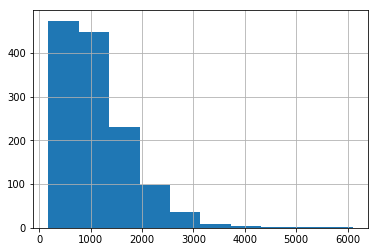

In [1095]:
data['Price_euros'].hist(bins=10);

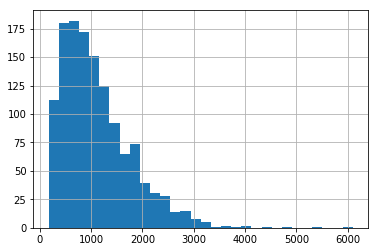

In [1096]:
data['Price_euros'].hist(bins=30);

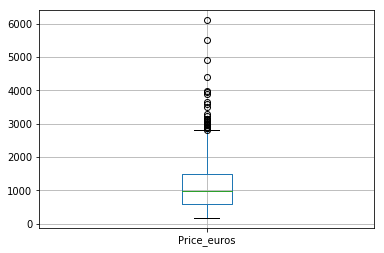

In [1097]:
data.boxplot('Price_euros');

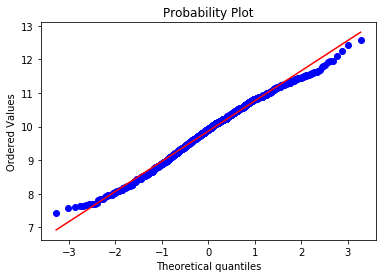

In [1098]:
stats.probplot(np.log2(data['Price_euros']), dist="norm", plot=plt);

Целевой признак распределен почти логнормально. Исключим ноутбуки c ценой больше 4000,считаем их выбросами 

In [1099]:
data = data[data['Price_euros']<4000]

#### Зависимость цены от производителя

In [1100]:
data.groupby('Company')['Price_euros'].median().sort_values(ascending=False)

Company
Razer        2599.00
LG           2099.00
Samsung      1649.00
MSI          1599.00
Microsoft    1569.50
Google       1559.00
Huawei       1424.00
Apple        1339.69
Toshiba      1211.50
Xiaomi       1099.45
Asus         1012.50
Dell          985.00
HP            960.00
Lenovo        899.00
Fujitsu       739.00
Acer          559.00
Mediacom      265.00
Chuwi         248.90
Vero          206.85
Name: Price_euros, dtype: float64

Ноутбуки Razer значительно дороже остальных, говорить о значимим отличии сложно, т.к. ноутбуков Razer всего 5 штук

In [1101]:
data['Company'].value_counts()

Dell         297
Lenovo       296
HP           273
Asus         158
Acer         103
MSI           54
Toshiba       48
Apple         21
Samsung        9
Mediacom       7
Microsoft      6
Razer          5
Vero           4
Xiaomi         4
Chuwi          3
LG             3
Google         3
Fujitsu        3
Huawei         2
Name: Company, dtype: int64

### 2.Визуальный анализ данных

Зависимость цены от производителя

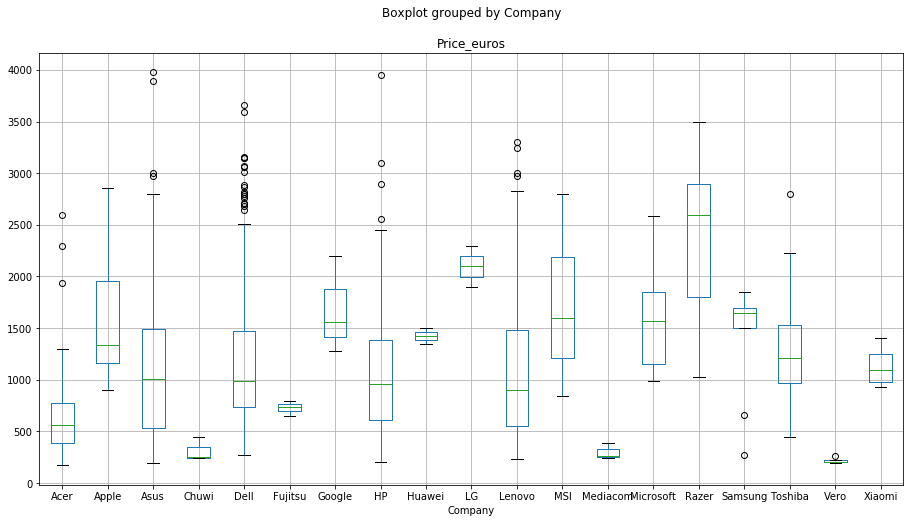

In [1102]:
fig, ax = plt.subplots(figsize=(15,8))
plt.suptitle('')
data.boxplot(column=['Price_euros'], by='Company',ax=ax);

In [1103]:
columns_drop = ['2 in 1 Convertible', 'Gaming',
       'Netbook', 'Notebook', 'Ultrabook', 'Workstation']

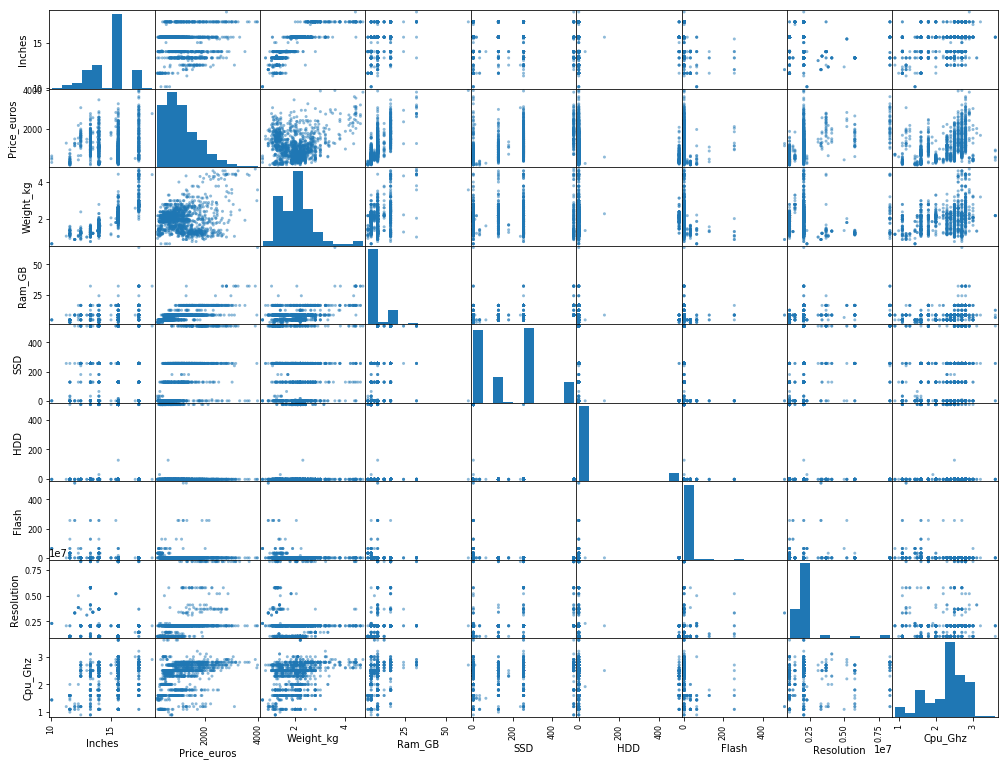

In [1104]:
pd.plotting.scatter_matrix(data.drop(columns_drop,axis=1), figsize=(17,13));

На Price влияет Ram, Inches, Hdd, Cpu_Ghz. Так же видно, что есть взаимосвязь между Weight и Inches.

In [1105]:
data.groupby('HDD')['Price_euros'].describe()

,count,mean,std,min,25%,50%,75%,max
HDD,,,,,,,,
0,1163.0,1166.416956,667.117522,174.0,649.0,1043.0,1515.775,3975.00
32,1.0,265.000000,NaN,265.0,265.0,265.0,265.000,265.00
128,1.0,590.000000,NaN,590.0,590.0,590.0,590.000,590.00
500,134.0,640.897239,345.108130,224.0,379.0,537.5,783.750,2103.34


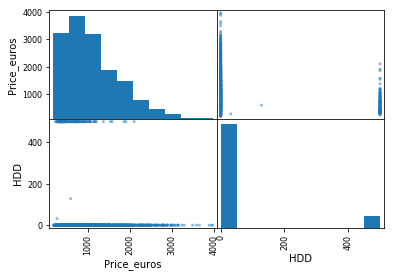

In [1106]:
pd.plotting.scatter_matrix(data[['Price_euros', 'HDD']], figsize=(6,4));

Чем больше размер HDD, тем меньше дорогих ноутбуков.

#### Матрица корреляций

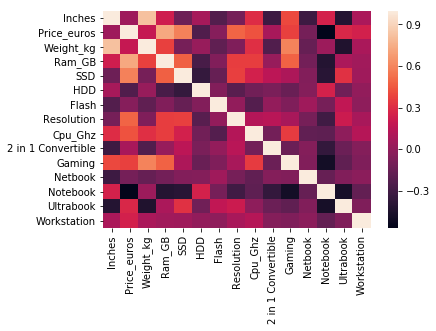

In [1107]:
sns.heatmap(data.corr());

Видим высокую корреляцию между Price и SR/Ram/SSD/CPU_Ghz(Ценой ноутбука с компонентами ноутбука), Inches и Weight, Weight и Gaming. Ноутбуки типа notebook умеренно коррелируют с HDD/Inches, ноутбуки типа Gaming коррелируют с Cpu_Ghz/Ram/Weight/Inches/Price

#### 1.4. Choose and display statistics for the observations.

#### Проверка гипотезы равенства средних цены в зависимости от производителя процессора

$$ Гипотеза  H_0 : M_{amd}=M_{intel}$$ 
$$ Гипотеза  H_1 : M_{amd} \neq  M_{intel}$$

In [1108]:
data['Cpu_company'] = data['Cpu'].apply(lambda x: x.split()[0])

In [1109]:
data["Cpu_company"].value_counts()

Intel      1236
AMD          62
Samsung       1
Name: Cpu_company, dtype: int64

#### 1.5. Visualise explored features and hypothesis

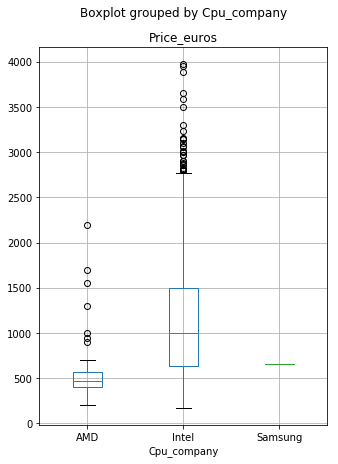

In [1110]:
fig, ax = plt.subplots(figsize=(5,7))
plt.suptitle('')
data.boxplot(column=['Price_euros'], by='Cpu_company',ax=ax)

In [1111]:
stats.ttest_ind(data[data['Cpu_company']=='AMD']['Price_euros'],data[data['Cpu_company']=='Intel']['Price_euros'])

Ttest_indResult(statistic=-6.839591246449107, pvalue=1.2206536568470352e-11)

#### Отклоняем нулевую гипотезу о равенстве средней стоимости

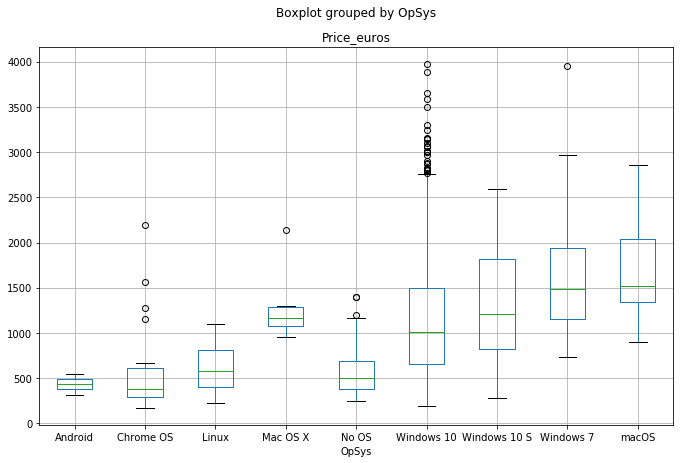

In [1112]:
fig, ax = plt.subplots(figsize=(11,7))
plt.suptitle('')
data.boxplot(column=['Price_euros'], by='OpSys',ax=ax);

In [1113]:
data['Gpu_'] = data['Gpu'].apply(lambda gpu: gpu.split()[0])

In [1114]:
data['Gpu_'].value_counts()

Intel     722
Nvidia    396
AMD       180
ARM         1
Name: Gpu_, dtype: int64

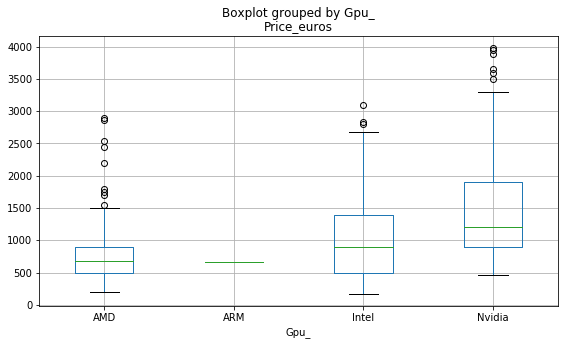

In [1115]:
fig, ax = plt.subplots(figsize=(9,5))
plt.suptitle('')
data.boxplot(column=['Price_euros'], by='Gpu_',ax=ax);

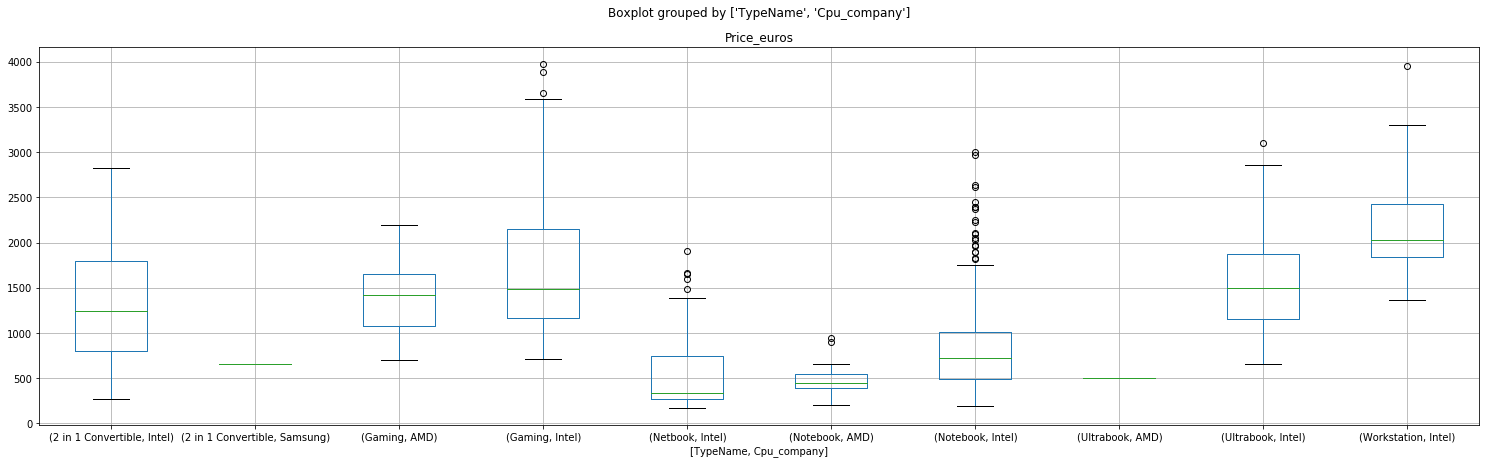

In [1116]:
fig, ax = plt.subplots(figsize=(25,7))
plt.suptitle('')
data.boxplot(column=['Price_euros'], by=['TypeName','Cpu_company'],ax=ax);

Преобразуем оставшиеся нечисловые признаки в числовые и удалим дублированные признаки

#### OneHotEncoding для категориальных признаков

In [1117]:
data.drop(['TypeName','Gpu_','ScreenResolution','Cpu_company'], axis=1,inplace=True)

In [1118]:
ohe = pd.get_dummies(data['OpSys'])
data = data.join(ohe)
data.drop('OpSys',axis=1,inplace=True)

In [1119]:
ohe = pd.get_dummies(data['Cpu'])
data = data.join(ohe)
data.drop('Cpu',axis=1,inplace=True)

In [1120]:
ohe = pd.get_dummies(data['Company'])
data = data.join(ohe)
data.drop('Company',axis=1,inplace=True)

In [1121]:
ohe = pd.get_dummies(data['Product'])
data = data.join(ohe)
data.drop('Product',axis=1,inplace=True)

In [1122]:
ohe = pd.get_dummies(data['Gpu'])
data = data.join(ohe)
data.drop('Gpu',axis=1,inplace=True)

In [1123]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1299 entries, 0 to 1302
Columns: 750 entries, Inches to Nvidia Quadro M620M
dtypes: float64(6), int64(3), uint8(741)
memory usage: 1.1 MB


Все признаки числовые